# 2 머신러닝 프로젝트 처음부터 끝까지

## 핵심 주제

선형 회귀 모델 학습을 소개하면서 머신러닝 프로젝트를 진행할 때 필요한 과정의 큰그림을 보여준다.

1. 문제 정의
1. 데이터 구하기
1. 큰 그림 보기
1. 훈련 세트와 테스트 세트 분류
1. 데이터 시각화
1. 데이터 전처리와 변환 파이프라인
1. 모델 선택과 훈련
1. 모델 세부 튜닝

## 파이썬 기본 설정

* 파이선 버전 3.5 이상
* 사이킷런 버전 0.20 이상
* 모듈 불러오기
    * numpy
    * matplotlib
    * matplotlib.pyplot
* 그림 저장 위치 지정
* 경고문 관련 옵션 지정

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 기본 모듈 임포트
import numpy as np
import os

# 그래프 관련
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림 저장 위치 지정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 핵심 1: 문제 정의

머신러밍 모델을 만드는 이유를 알아야 한다.
여기서는 부동산 회사에서 활용할 목적으로 캘리포니아의 구역별 주택 가격을 예측하는 모델을 구현하고자 한다.
이를 위해 아래 질문에 답해야 한다.

* 지도 학습 또는 비지도 학습 또는 강화 학습?
    * 조사된 주택 가격 레이블을 활용한 훈련이 가능하다.
    * 답: 지도 학습
* 분류 또는 회귀?
    * 중간 주택 가격을 저렴, 보통, 고가 등 범주(카테고리)로 분류하는 게 아니라 가격을 예측한다.
    * 답: 회귀.
        보다 구체적으로는 여러 특성을 활용하는 다중 회귀이며,
        구역별로 하나의 가격만 예측 하기에 단변량 회귀이다.
* 배치 학습 또는 온라인 학습?
    * 빠르게 변하는 데이터에 적응할 필요 없다.
    * 답: 배치 학습

## 핵심 2: 데이터 구하기

공개 데이터 저장소에서 많은 데이터셋을 구해 머신러닝 실전 훈련을 진행할 수 있다.
여기서 다루는 데이터는 StatLib 저장소에 있는 캘리포니아 주택 가격 데이터이다.
* 1990년 캘리포니아 인구조사 데이터
* 학습용으로 매우 좋은 데이터
* 교육 목적으로 범주형 특성 추가 및 개 특성 제외

<p>
<table cellspacing="20">
<tr>
<td>
<img src="https://github.com/liganega/handson-ml2/blob/master/notebooks/images/end_to_end_project/LA-map04.jpg?raw=1">
</td>
<td>
<img src="https://github.com/liganega/handson-ml2/blob/master/notebooks/images/end_to_end_project/LA-map02-1.jpg?raw=1">
</td>
</tr>
</table>
</p>

### 데이터 가져오는 함수

온라인 상에 위치한 데이터를 가져오는 함수를 구현해 두면 다양하게 재활용 할 수 있다.

In [ ]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/liganega/handson-ml2/master/notebooks/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# tar 파일을 가져와서 지정된 폴더에 압축을 풀면 csv 파일 저장됨.
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
fetch_housing_data()

저장된 csv 파일을 pandas의 데이터프레임으로 가져오는 함수를 선언해서 사용한다.

In [ ]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

## 핵심 3: 큰 그림 보기

가져온 데이터의 특성과 형식에 대한 큰 그림을 그려야 한다.

### 데이터 구조 확인

먼저 가져온 데이터가 어떤 구조로 구성되었는지 첫 다섯 개의 데이터를 확인해보자.

In [ ]:
housing.head()

마지막 다섯 개의 데이터는 다음과 같다.

In [ ]:
housing.tail()

### 데이터 정보 요약

인덱스가 20639로 끝나는 것으로 보아 20,640개의 샘플이 있음을 알 수 있다.
물론 중간에 인덱스가 몇 개 빠져있을 수도 있다.
그래서 아래와 같이 캘리포니아 인구조사 데이터에 대한 간략한 정보를 확인해보자.

In [ ]:
housing.info()

정보 내용은 다음과 같다.

* 총 20,640개의 샘플 포함
    * 캘리포니아를 20,640 구역으로 나뉘어 조사한 인구조사
    * 구역 크기: 600명 ~ 3,000명
* 구역별로 총 10개의 항목이 조사되었음.
    * 경도(longitude)
    * 위도(latitude)
    * 중간 주택 연도(housing median age)
    * 방의 총 개수(total rooms)
    * 침실의 총 개수(total bedrooms)
    * 인구(population)
    * 가구 수(households)
    * 중간 소득(median income)
    * 중간 주택 가격(median house value)
    * 해안 근접도(ocean proximity)
* 해안 근접도를 제외한 나머지 9개 항목은 부동소수점(float64), 즉 수치형 값을 사용한다.
    해안 근접도에서 사용된 자료형인 object는 임의의 자료형이 사용될 수 있음을 의미하며,
    실제로는 문자열이 사용되었다.
    따라서 해안 근접도는 **범주형 데이터**이고 나머지는 **수치형 데이터**이다.
* 방의 총 개수(total_bedrooms)의 경우 누락된 데이터 존재
    * 207개 구역의 값이 널(null)값, 즉, 누락되었음.
    * 저자가 의도적으로 누락시킨 것으로 보임.
    * 전처리 과정에서 누락된 데이터를 어떻게 처리하는지 배울 것임.

### 목표 설정

데이터 구조를 보면 총 10개의 특성을 보여준다.
중간 주택 가격을 제외한 9개의 특성을 이용하여 구역별로 중간 주택 가격을 예측하는 회귀 모델을 생성하고자 한다.
이를 위해 실제로 조사된 중간 주택 가격을 레이블(타겟)으로 사용한다.

<p>
<table cellspacing="20">
<tr>
<td>
<img src="https://github.com/liganega/handson-ml2/blob/master/notebooks/images/end_to_end_project/LA-map01b.jpg?raw=1">
</td>
</tr>
</table>
</p>

### 범주형 데이터 탐색

해안 근접도는 아래 5개 범주로 구분된다.

* <1H OCEAN: 1시간 이내
* INLAND: 내륙
* NEAR OCEAN: 해안 근처
* NEAR BAY: 샌프란시스코 만 근처 도시 중심 지역.
    특히 베이 에어리어(Bay Area) 지역에 값비싼 주택들이 몰려있다.
* ISLAND: 섬

범주별 도수는 다음과 같다.

In [ ]:
housing["ocean_proximity"].value_counts()

### 수치형 데이터 탐색

수치형 데이터를 다루는 9개 항목에 대한 자세한 정보를 다음과 같이 알아 본다.
`describe()` 메서드는 수치형 데이터들에 대한 간략한 통계정보를 전달한다.

In [ ]:
housing.describe()

확인된 수치형 특성의 정보는 다음과 같다.

* count: 널값 제외 데이터 수
* mean: 평균값
* std: 표준편차
* min: 최소값
* 25%: 제1사분위수
* 50%: 중앙값
* 75%: 제3사분위수
* max: 최대값

특성에 따라 최대값과 제3사분위수의 차이가 매우 큰 경우가 존재한다.
이는 해당 특성에 이상치가 존재함을 의미한다.

### 그래프 활용

수치형 데이터를 다루는 9개 항목을 각각 히스토그램으로 표현할 수 있다.
히스토그램의 x축(수평축)과 y축(수직축)의 숫자가 가리키는 의미는 다음과 같다.

* x축: 특성 값의 구간
* y축: 구간별 샘플 수

아래에서는 특성값을 모두 50개의 구간(`bins=50`)으로 분류하였다.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

히스토그램의 주요 특징은 다음과 같다.

* 중간 소득(median income)
    * 미국 달러 단위 아님.
    * 스케일 조정 후 상한과 하한 지정
        * 상한: 15 (15만 달러)
        * 하한: 0.5 (5천 달러)
    * 이와 같이 전처리(preprocessing)는 일반적임.
* 중간 주택 연도(housing median age)와 중간 주택 가격(media house value)
    * 최댓값 제한
    * 중간 주택 연도의 경우 특성으로 사용되기에 문제 될 수 있음.
    * 한계 밖의 값(이상치)들을 어떻게 다룰지 선택해야 함.
        * 선택 1: 정확한 값 확인 후 사용
        * 선택 2: 훈련 세트에서 제거
* 특성들 사이의 스케일 다름. 이후 조정할 것임.
* 많은 히스토그램에서 오른편 꼬리가 두꺼움.
    * 머신러닝 알고리즘의 패턴 찾기를 어렵게 만듦
    * 종 모양의 분포가 되도록 변형시키는 방법을 나중에 다룰 것임.

## 핵심 4: 훈련 세트와 테스트 세트 분류

모델 학습 시작하기 이전에 준비된 데이터 셋을 훈련 세트와 테스트 세트로 나누어야 한다.
테스트 세트에 포함된 데이터는 미리 분석하지 않는다.
미리 분석하면 **데이터 스누핑** 편향을 범할 가능성이 높아진다.
즉, 미리 엿보면서 알아낸 직관이 학습 모델 설정에 영향을 끼칠 수 있다.

* 테스트 세트 크기: 보통 전체 데이터셋의 20%

훈련 세트와 테스트 세트를 구분하는 방식에 따라 결과가 조금씩 달라진다.
아래에서 무작위 샘플링(random sampling) 방식과 계층적 샘플링(stratified sampling) 방식의
차이점을 예를 들어 설명한다.

테스트 세트 생성은 머신러닝 프로젝트에서 매우 중요하다.
여기서는 계층적 샘플링을 사용하여 훈련 세트와 테스트 세트를 분류하여 모델 학습에 사용한다.

### 무작위 샘플링

지정된 비율에 따라 무작위적으로 데이터를 분류하는 것을 **무작위 샘플링**(random sampling)이라 부른다.
여기서는 두 가지 방식을 소개한다.

* 넘파이 `random` 모듈 활용
* 식별자 기준 분류

#### 넘파이 `random` 모듈 활용

`random` 모듈의 `permutation` 함수를 이용하여 샘플을 무작위적으로 섞는다.
그런데 이렇게 하면 동일한 기준으로 재분류하는 것이 불가능해진다.
시드(seed) 지정을 통해 난수 발생기의 초깃갑 지정 가능하다.
하지만 이후에 데이터가 추가되는 경우 난수 초깃값 지정하는 것이 별 도움이 되지 않는다.

In [ ]:
# 노트북의 실행 결과가 동일하도록
np.random.seed(42)

In [ ]:
import numpy as np

# 예시로 만든 것입니다. 실전에서는 사이킷런의 train_test_split()를 사용하세요.
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

훈련 세트와 테스트 세트를 무작위로 분류한다.

In [ ]:
train_set, test_set = split_train_test(housing, 0.2)

테스트 세트의 비율은 20%이다.

In [ ]:
len(test_set)/len(housing)

#### 식별자(id) 기준 분류

* 데이터 샘플의 고유 정보를 활용하여 분류.
* 예를 들어, 식별자(id)의 해시값을 계산하여 해시 최댓값의 20%보다 작거나 같은 샘플만 테스트 세트로 분류.

In [ ]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

#####  식별자 예제: 인덱스(index)

* 인덱스를 식별자로 활용.
* 주의사항
    * 새 데이터는 데이터셋의 끝에 추가되어야 함.
    * 기존 데이터는 절대 삭제하지 말아야 함.

In [ ]:
housing_with_id = housing.reset_index()   # `index` 열이 추가된 데이터프레임을 반환합니다
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [ ]:
test_set.head()

#####  식별자 예제: 위도와 경도

추가되는 데이터를 데이터셋 끝에 추가하거나 기존 데이터를 유지하는 일이 불가능 할 경우
인덱스가 불가피하게 달라진다.
이럴 때는 변하지 않는 정보를 식별자로 활용해야 한다.
예를 들어, 위도와 경도의 조합을 식별자로 활용할 수 있다.

* 위도와 식별자는 몇백 년 동안 거의 변하지 않음.
* 새로운 데이터를 임의로 추가해도 항상 동일한 결과를 얻을 수 있음.

In [ ]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [ ]:
test_set.head()

#### 사이킷런 제공 분류 함수

사이킷런에 포함된 `train_test_split` 난수 초깃값을 지정하는 옵션 기능과
인덱스를 식별자로 활용하는 기능을 모두 제공한다.
* `random_state`: 난수 초깃값 지정 옵션 변수
* 동일한 크기의 여러 개의 데이터셋에 대해 동일한 인덱스를 기반으로 나눌 수 있음.
    * 동일 데이터 셋에 대해 레이블의 종류에 따라 다른 데이터프레임이 제공되었을 때 유용하게 활용됨.

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
test_set.head()

### 계층적 샘플링

설문조사를 시행할 때 여러 요소를 고려한 후 조사 대상자를 무작위적으로 선택해야 한다.

* 남, 녀 비율
* 지역인구 비율
* 나이 비율 등등

이와 같은 방법을 **계층적 샘플링**(stratified sampling)이라 부른다.
여기서 **계층**은 남, 녀, 나이, 직업 등 동질 그룹을 의미하며,
테스트 세트가 전체 계층을 대표하도록 각 계층별로 적절하게 샘플을 추출해야 한다.
이를 위해 먼저 계층 기준을 정해야 한다.
예를 들어, 소득을 기준으로 사용할 수 있다.

먼저, 소득 카테고리(범주)를 지정해야 하며,
각 계층별로 충분한 크기의 샘플이 포함되어야 학습과정에서 편향이 발생하지 않는다.
예를 들어, 특정 소득 구간에 포함된 샘플이 과하게 적거나 많으면 해당 계층의
중요도가 과대 또는 과소 평가될 것이다.

먼저 전체 데이터셋의 중간 소득 히스토그램을 확인해 보자.

In [ ]:
housing["median_income"].hist()

대부분 구역의 중간 소득이 1.5-6.0(15,000 - 60,000 달러) 사이임을 확인할 수 있다.
여기서는 소득 구간을 아래 숫자들을 기준으로 5개로 나눈다.

    [0., 1.5, 3.0, 4.5, 6., np.inf]

또한 구간별 소득 카테고리를 1부터 5까지로 지정한다.
이 과정을 판다스의 `cut` 함수를 이용하여 실행하면, 결과물을 새로운 특성으로
기존의 데이터셋에 추가한다.
여기서 특성 열의 이름은 `"income_cat"`으로 지정한다.

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

소득 구간별로 전체 데이터셋을 구분한 결과는 다음과 같다.

In [ ]:
housing["income_cat"].value_counts()

히스토그램을 그려보자.

In [ ]:
housing["income_cat"].hist()

이제 소득 카테고리를 이용한 계층 샘플링을 할 수 있다.
이를 위해 사이킷런의 `StratifiedShuffleSplit` 클래스를 활용한다.

* 계층적 샘플링을 위한 도구 상자
* `split` 메서드: 지정된 비율로 훈련 및 테스트 세트로 계층적 샘플링 실행

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

아래 두 세트를 앞으로 학습 모델을 위해 사용한다.

* `strat_train_set`: 훈련 세트
* `strat_test_set`: 테스트 세트

소득 카테고리 별 비율이 유지되도록 분류되었음을 확인할 수 있다.

* 테스트 세트에서의 계층별 비율

In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

* 전체 데이터셋에서의 계층별 비율

In [ ]:
housing["income_cat"].value_counts() / len(housing)

* 무작위 샘플링과 계층적 샘플링 결과 비교

In [ ]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

계층적 샘플링이 계층별 비율을 보다 더 잘 반영하였음을 아래에서 확인할 수 있다.

* Overall: 전체 데이터셋의 계층별 비율
* Stratified: 계층별 샘플링으로 분류된 테스트 세트의 계층별 비율
* Random: 무작위 샘플링으로 분류된 테스트 세트의 계층별 비율
* Rand. %error: Random 결과의 오차율
* Strat. %error: Stratified 결과의 오차율

**주의:** 오차율이 낮을 수록 계층별 비율이 보다 잘 유지되었음을 의미함.

In [ ]:
compare_props

#### `incom_cat` 특성 삭제

계층적 샘플링을 위해 위해 임시로 생성된 `incom_cat` 특성은 더 이상 필요없다.
따라서 해당 특성을 삭제하여 원래 상태로 되돌려야 한다.

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 핵심 5: 데이터 시각화

앞서 설명한 대로 테스트 세트를 제외한 훈련 세트에 대해서만 시각화를 이용하여 탐색한다.
훈련 세트가 매우 큰 경우 탐색을 위한 샘플링을 따로 만들 수도 있다.
하지만 캘리포니아 인구조사 데이터셋은 작은 편이기에 전체 훈련 세트를 이용하여 시각화 탐색을 알아본다.

먼저 원본 훈련 세트를 손상시키지 않기 위해 복사본을 만들어 시각화를 진행한다.

**주의:** `housing`이 지금까지는 원본 전체 데이터셋을 가리켰다.
하지만 이제부터는 훈련 세트 복사본을 가리킨다.

In [ ]:
housing = strat_train_set.copy()

### 지리적 데이터 시각화

위도와 경도의 지리 정보를 이용하여 20,640 개 구역의 분포를 산점도(scatter)를 이용하여 확인한다.

* 데이프레임의 `plot()` 메서드의 `kind` 옵션 변수의 인자로 `"scatter"` 사용.
* x축(수평축): 경도(longitude)
* y축(수직축): 위도(latitude)
* `save_fig()`: 사진 저장 함수.

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

`alpha` 옵션 변수의 값을 0.1로 지정하면 구역이 집결된 지역과 그렇지 않은 지역의 구분을 보다
명확하게 나타낼 수 있다. `alpha`의 기본값은 1이다.

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

캘리포니아 지도와 비교했을 때, 샌프란시스코의 베이 에어리어, LA, 샌디에고 등 밀집된 지역이 눈에 잘 띄며,
대도시를 따라 밀집된 지역이 긴 띠를 이루는 것을 볼 수 있다.

아래 옵션 변수를 추가해서 사용하면 보다 다양한 정보를 확인할 수 있다.
* `s` 옵션 변수: 구역의 인구를 원의 반지름으로 사용
* `c` 옵션 변수: 중간 주택 가격을 색상 기준으로 사용.
* `cmap` 옵션 변수: `"jet"`로 지정하면 낮은 주택 가격은 파란색, 높은 주택 가격은 빨간색으로 표시.

**주의:** `sharex=False` 옵션 변수: x-축의 값과 범례를 표시하지 못하는 임시방편 버그 수정용.

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

* 주택 가격이 해안 근접도와 인구 밀도에 관련이 큼을 확인할 수 있다.
* 인구 밀도: 9장에서 소개하는 비지도 학습법 중의 하나인 군집 알고리즘(clustering algorithm)을 사용하여
    주요 군집을 찾고 중심가지의 거리를 재는 특성을 추가할 수 있다.
* 해안 근접도: 위치에 따라 다르게 작용한다. 예를 들어, 대도시 근처는 해안 근처 주택 가격이 상대적으로 높지만
    북부 캘리포니아 지역은 별로 그렇지 않다. 따라서 규칙 찾기가 어려울 수 있다.

#### 이미지 합성

산점도와 실제 캘리포니아 지도를 합성하면 구역별 정보가 보다 생생하게 확인된다.

* 캘리포니아 지도 다운로드 하기

In [ ]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

* 경도, 위도, 인구 밀집도, 주택 가격과 관련된 산포도를 캘리포니아 지도와 합성한다.
* 오른편 색상 범례는 중간 주택 가격을 보다 세밀하게 구분하여 보여줌.
    * 넘파이의 `linspace`를 이용하여 주택 가격을 균등하게 10개 구간으로 구분하였다.
    * 하지만 가격을 천 단위로 표기하면서 일부 구간이 합쳐지면서 7개 구간으로 구분된 것으로 보인다.

In [ ]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

### 상관관계

특성들 **표준 상관계수**(standard correlation coefficient)를 계산하여
특성들 사이의 선형관계 정도를 확인한다.
표준 상관계수는 **피어슨(Pearson) 계수 $r$** 이라고도 불린다.

In [ ]:
corr_matrix = housing.select_dtypes(include=[np.number]).corr()

중간 주택 가격 특성과 다른 특성 사이의 상관관계를 확인해보자.

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

상관계수의 특징은 다음과 같다.

* 상관계수: $[-1, 1]$ 구간의 값
* 1에 가까울 수록: 강한 양의 선형 상관관계
* -1에 가까울 수록: 강한 음의 선형 상관관계
* 0에 가까울 수록: 매우 약한 선형 상관관계

따라서 아래 정보가 확인된다.

* 중간 주택 가격과 중간 소득의 상관계수: 0.68
    * 중간 소득이 올라가면 중간 주택 가격도 상승하는 경향이 꽤 있음.
* 위도와 중간 주택 가격 사이의 상관계수: -0.14
    * 위도가 커질 수록, 즉, 북쪽으로 갈 수록 주택 가격이 미세하게 내려가는 경향 있음.

#### 다양한 상관계수

![Pearson correlation coefficient](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)

참조: [위키백과](https://ko.wikipedia.org/wiki/피어슨_상관_계수)

##### 주의사항

* 상관계수가 0에 가까울 때: 선형 관계가 거의 없다는 의미이지, 아무런 관계가 없다는 의미는 아님.
* 상관계수는 기울기와 아무 연관 없음.

#### 산점도와 상관계수

* 산점도를 이용하여 선형관계를 어느 정도 파악할 수 있음.
* 판다스의 `scatter_matrix` 함수
    * 수치형 특성들 사이의 산점도를 한꺼번에 그려줌.
    * 사용하는 특성의 수가 너무 크면 경우의 수가 너무 커짐에 주의.
        * 예를 들어, `housing` 훈련 세트는 10개의 특성 중 해안 근접도(ocean proximity)를
            제외한 9개 특성이 수치형 특성이기에,
            9개 전체에 대해 산점도를 그리명 총 9$\times$9 = 81개가 그려짐.
* 참고: 데이터프레임의 `plot` 메서드를 `kind="scatter"` 로 지정하면 하나의 산점도만 그림

여기서는 중간 주택 가격과 높은 연관성을 갖는 것으로 보이는 네 개의 특성들 사이의 산점도를 그린다.
즉, 총 16개의 산점도가 그려진다.

* 중간 주택 가격
* 중간 소득
* 방의 총 개수
* 중간 주택 연도

**주의:** 대각선에 위치한 산점도는 해당 특성에 대한 것이기 때문에 그냥 직선이 되며 별 의미가 없음.
따라서 해당 특성의 히스토그램이 기본으로 그려짐.

In [ ]:
# from pandas.tools.plotting import scatter_matrix # 옛날 버전의 판다스에서는
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

위 산점도 중에서 중간 소득과 중간 주택 가격 사이의 산점도가 가장 높은 상관관계를 보여준다.
따라서 두 특성 사이의 산점도를 확대해서 살펴보자.

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

* 상관관계가 매우 큼.
* 하지만 점들이 너무 넓게 퍼져 있음.
* 50만 달러 수평선: 가격 제한
* 35만, 28만, 그리고 그 아래 정도에서도 수평선 존재
* 이런 이상한 형태를 학습하지 않도록 해당 구역을 제거하는 것이 좋음.

### 특성 조합 실험

* 구역별 방의 총 개수와 침실의 총 개수는 자체로 별 의미 없음.
* 대신에 가구당 방 개수(rooms for household), 방 하나당 침실 개수(bedrooms for room),
    가구당 인원(population per household) 등이 보다 의미 있는 특성임.
* 데이터프레임을 활용하여 쉽게 특성들의 조합을 쉽게 구성할 수 있음.

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

추가된 특성들에 대한 요약 정보도 함께 확인해보자.

In [ ]:
housing.describe()

이제 특성별 상관계수를 다시 확인한다.

In [ ]:
corr_matrix = housing.select_dtypes(include=[np.number]).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

중간 주택 가격과 방 하나당 침실 개수의 상관계수가 -0.26 정도이다.
즉, 방 하나당 침실 개수가 적을 수록 주택 가격이 상승하는 경향을 갖는다.
아래 산점도에서 확인할 수 있다.

In [ ]:
housing.plot(kind="scatter", x="bedrooms_per_room", y="median_house_value",
             alpha=0.2)
plt.show()

산점도 등을 통한 탐색은 불완전한다. 하지만
데이터에 대한 통찰을 위해 이런 탐색 과정을 반복적으로 실행해야 한다.
즉, 프로토타입을 만들고 실행한 후 그 결과를 분석해서 더 많은 통찰을 얻고 다시 탐색 단계로 돌아오는 과정응 반복해야 한다.

## 핵심 6: 데이터 전처리와 변환 파이프라인

이제 머신러닝 모델 학습을 위해 데이터를 준비한다.
먼저, 원래 계층형 샘플링을 통해 생성된 훈련 세트로 복원해야 한다.
동시에 학습에 사용되는 특성과 레이블(타깃)을 구분한다.

**주의:** `drop()`과 `copy()` 메서드 모두 원본을 변형시키지 않고 사본을 생성한다.

In [ ]:
# 중간 주택 가격을 빼고 훈련 세트로 지정
housing = strat_train_set.drop("median_house_value", axis=1)

# 중간 주택 가격은 레이블(타깃)으로 활용
housing_labels = strat_train_set["median_house_value"].copy()

모델 학습을 효율적으로 진행하기 위해 주어진 데이터를 변환시켜야 하며,
이를 **데이터 전처리**(data preprocessing)라고 한다.
여기서는 수치형 데이터와 범주형 데이터에 대해 다른 변환과정을 사용한다.

* 수치형 데이터 전처리 과정
    * 데이터 정제
    * 조합 특성 추가
    * 특성 스케일링
* 범주형 데이터 전처리 과정
    * 원-핫-인코딩(one-hot-encoding)
    
수치형 데이터 전처리 과정에 사용된 세 가지 변환과정은 파이프라인을 이용하여 자동화한다.
이후 원-핫-인코딩 변화과정으로 변환된 범주형 데이터화 결합하면서 전처리 과정이 완료된다.

### 사이킷런 API 활용

언급된 변환과정 중에서 '조합 특성 추가' 과정을 제외한 나머지 과정은 사이킷런에서 제공하는
관련 API를 활용한다.
'조합 특성 추가' 과정도 다른 사이킷런 API와 호환이 되는 방식으로 사용자가 직접 구현하는 방법을 설명한다.

사이킷런에서 제공하는 API는 일관되고 단순산 인터페이스를 제공한다.
이 성질을 이용하여 '조합 특성 추가' 과정을 지원하는 API를 구현하면 사이킷런의 다른 API와
자동으로 호환된다.

사이킷런 API의 주요 설계 원칙은 다음과 같다.

#### 원칙 1: 일관성

모든 사이킷런의 API는 일관되고 단순한 인터페이스를 제공한다.
대표적인 API는 아래 세 가지이다.

* 추정기(estimator)
    * 데이터셋을 기반으로 특정 모델 파라미터들을 추정하는 클래스의 객체이며,
        `fit()` 메서드가 이 기능을 수행한다.
    * `fit()`메서드의 리턴값: 생성된 모델 파라미터를 인스턴스 속성으로 갖는 `self`.
        즉, 특정 속성이 업데이트된 객체 자신을 리턴값으로 내준다.
    * 예제
        * 누락된 수치형 특성 데이터를 특정 값으로 채우기 위해 사용되는
            `SimpleImputer` 클래스.
            사용되는 특정 값은 `fit()` 메서드가 계산한다.
        * 모델 학습을 통해 가중치와 편향을 계산하여 선형 모델을 구현하기 위해
            사용되는 `LinearRegression` 클래스.
            모델 학습과정을 통해 가중치화 편향 계산은 `fit()` 메서드가 수행한다.
* 변환기(transformer):
    * 데이터셋을 변환하는 추정기이며, `transform()`가 이 기능을 수행한다.
        즉, 변환기는 `fit()`과 `transform()` 모두 포함되어 있어야 한다.
    * 보통 `fit()` 메서드에 의해 학습된 파라미터를 이용하여 데이터셋을 변환한다.
    * 모든 변화기는 `fit()` 메서드와 `transform()` 메서드를 연속해서 호출하는
        `fit_transform()` 메서드를 함께 제공한다.
    * 예제
        * 누락된 수치형 특성 데이터를 특정 값으로 채우기 위해 사용되는
            `SimpleImputer` 클래스.
            누락된 값을 삽입하여 새로운 데이터셋을 생성하는 일은 `transform()` 메서드가 수행한다.
        * 수치형 특성의 데이터를 표준화하여 새로운 데이터셋을 생성하는 데에 사용되는
            `StandardScaler` 클래스.
            표준화를 통한 스케일링은 `transform()` 메서드가 수행한다.
* 예측기(predictor): 데이터셋의 특정 특성에 대한 예측을 하는 추정기
    * 주어진 데이터셋과 관련된 값을 예측하는 기능을 제공하는 추정기이며, `predict()` 메서드가
        이 기능을 수행한다.
        즉, `fit()`과 `predict()` 메서드가 포함되어 있어야 한다.
    * `predict()` 메서드가 추정한 값의 성능을 측정하는 `score()` 메서드도 포함한다.
    * 일부 예측기는 추정치의 신뢰도를 평가하는 기능도 제공한다.
    * 예제
        * 훈련을 통해 학습된 가중치와 편향을 이용하여 특정 값(레이블)을 추정하는
            `LinRegression` 선형 모델 클래스.
            새로운 데이터셋이 입력되면 그에 상응하는 예측을 실행하여 새로운 데이터셋을 생성하는
            기능은 `predict()` 메서드가 수행한다.


#### 원칙 2: 확인 가능성

* 추정기의 하이퍼파라미터와 학습된 파라미터는 모두 공개됨
* 학습된 파이미터의 경우 접미사로 밑줄 사용

#### 원칙 3: 클래스 남용 방지

* 클래스 대신 넘파이 어레이 또는 사이파이(SciPy)의 희소 행렬 사용
* 하이퍼파라미터는 문자열 또는 숫자 사용

#### 원칙 4: 조합성

* 기존 API를 최대한 재사용함.
* 여러 개의 변환기를 연결한 다음 마지막에 추정기를 하나 배치시켜서
    `Pipeline` 추정기를 새로 만들어서 다양하게 활용한다.

#### 원칙 5: 합리적 기본값

* 모든 API가 합리적인 옵션 변수의 기본값을 지원한다.
* 이를 통해 기본 시스템을 빠르게 만들 수 있다.

이제부터 사이킷런의 API를 이용하거나 사이킷런의 API와 호환되는 사용자 정의 클래스를 선언하여
데이터 전처리를 수행하는 과정을 살펴본다.

### 수치형 데이터 전처리 과정 1: 데이터 정제

누락된 특성값이 있으면 해당 값 또는 특성을 먼저 처리하고 모델 학습을 진행해야 한다.
여기서는 수치형 특성의 일부 데이터가 누락된 것을 처리하는 방법을 소개한다.

앞서 `total_bedrooms` 특성에 207개 구역에 대한 값이
널 값으로 채워져 있음을 확인하였다. 즉, 일부 구역에 대한 정보가 누락된 것이다.
누락된 구역을 아래와 같이 확인할 수 있다.

In [ ]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

널 값은 아래 세 가지 중 한 가지 방법으로 처리한다.

* 해당 구역 제거: `dropna()` 메서드 활용

In [ ]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

* 전체 특성 삭제: `drop()` 메서드 활용

In [ ]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)

* 특정 값으로 채우기 (0, 평균값, 중앙값 등): `fillna()` 메서드 활용.
    예를 들어, 중앙값으로 채우려면 아래와 같이 `median()` 메서드 활용.

In [ ]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # 옵션 3

In [ ]:
sample_incomplete_rows

여기서는 사이킷런의 `SimpleImputer` 변환기를 사용하여 널값을 모두 중앙값으로 채우는
방법을 사용한다.

* 중앙값을 사용하는 `SimpleImputer` 변환기 준비

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

* 중앙값이 수치형 특성에서만 계산될 수 있기 때문에 범주형 특성 삭제

In [ ]:
housing_num = housing.drop("ocean_proximity", axis=1)
# 다른 방법: housing_num = housing.select_dtypes(include=[np.number])

* 특성별 중앙값 계산: `fit()` 메서드 활용

In [ ]:
imputer.fit(housing_num)

* 계산된 특성별 중앙값 확인

In [ ]:
imputer.statistics_

* 수동으로 계산한 특성별 중앙값과 일치하는지 학인 가능

In [ ]:
housing_num.median().values

In [ ]:
housing_num.median().values == imputer.statistics_

* 훈련 세트 변환: `transform()` 메서드 활용

In [ ]:
X = imputer.transform(housing_num)

* 변환된 넘파이 어레이를 다시 데이터프레임으로 변환

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

* `total_bedrooms` 특성의 널 값이 중앙값으로 채원진 것 확인 가능

In [ ]:
housing_tr.loc[sample_incomplete_rows.index.values]

* 사용된 하이퍼파라미터가 중앙값이라는 것 확인.

In [ ]:
imputer.strategy

* 모든 널값이 채워진 상태의 새로운 훈련 세트 확인

In [ ]:
housing_tr.head()

### 범주형 데이터 전처리 과정: 원-핫-인코딩

대부분의 머신러닝 모델은 수치형 데이터만 다룬다.
따라서 범주형 입력 특성인 해안 근접도(`ocean_proximity`)를 수치형 데이터로 변환하도록 하자.

먼저 해안 근접도에 사용된 값들을 확인해보자.

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

#### 단순 수치화

사이킷런의 `OrdinalEncoder` 변환기 클래스를 이용하여 사용된 5개의 카테고리를
0, 1, 2, 3, 4의 수로 대체해보자.

* 5종류의 범주가 존재한다는 것을 확인하고 해당 범주
    대신에 0, 1, 2, 3, 4를 삽입하여 기존 데이터셋을 변환하는 `fit_transform()` 메서드가 사용됨.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

* 사용된 범주 5개 확인 가능.
    일반적으로 범주형 특성마다 1차원 어레이가 생성됨.
    사용된 범주형 특성이 하나이므로, 1차원 어레이 하나로 구성된 리스트로 확인됨.

In [ ]:
ordinal_encoder.categories_

#### 단순 수치화의 문제점

해안 근접도는 단순히 구분을 위해 사용되었다.
즉, 해안에 근접하고 있다 해서 주택 가격이 기본적으로 더 비싼 것은 아니라는 의미이다.
반면에 수치화된 값들은 크기를 비교할 수 있는 숫자들이다. 따라서
모델 학습 과정에서 숫자들의 크기 때문에 잘못된 학습이 이루어질 수 있다.

이를 방지하기 위해 보통 **원-핫-인코딩**(one-hot-encoding)을 사용한다.

#### `OneHotEncoder` 변환기

수치화된 범주들 사이의 크기비교를 피하기 위해 **더미**(dummy) 특성을 추가하여 활용한다.
생성되는 더미 특성은 사용된 범주를 사용한다.

예를 들어, 해안 근접도 특성 대신에 다섯 개의 범주 전부를 새로운 특성으로 추가한다.
그리고 각각의 특성값을 아래와 같이 정해진다.

* 해당 카테고리의 특성값: 1
* 나머지 카테고리의 특성값: 0

예를 들어, 앞서 살펴본 인덱스 17606번의 해안 근접도 특성값이 `<1H OCEAN` 이었다.
그러면 변환된 훈련 세트에서는 `<1H OCEAN`의 특성값만 1이고 나머지 네 개의 특성값은 0이 된다.

원-핫-인코딩은 사이킷런의 `OneHotEncoder` 변환기를 이용하면 된다.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

`OneHotEncoder`의 `transform()` 메서드는
기본적으로 **희소 행렬**을 내준다.
해안 근접도의 경우 일반 행렬로 표현하면 16512x5 크기의 행렬, 즉 2차원 어레이이다.
즉, 16,512개의 훈련 샘플에 대한 해안 근접도을 모두 길이가 5인 1차원 벡터로 표현한 것을 담고 있다.

* `toarray()` 메서드: 일반 행렬 모양의 2차원 어레이로 변환

In [ ]:
housing_cat_1hot.toarray()

* `sparse_output` 옵션 변수를 `False`로 지정하면 바로 2차원 어레이로 변환.

In [ ]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

* 사용된 범주 확인

In [ ]:
cat_encoder.categories_

### 수치형 데이터 전처리 과정 2: 조합 특성 추가, 나만의 변환기

특성을 추가하기 위해 변환기 클래스를 직접 정의한다.
여기서는 앞서 살펴본 다음 세 가지 특성을 자동으로 추가하는 변환기 클래스를 정의한다.

* 가구당 방 개수(rooms for household)
* 방 하나당 침실 개수(bedrooms for room)
* 가구당 인원(population per household)

변환기 클래스를 선언하기 위해서는 `fit()` 메서드와 `transform()` 메서드만 정의하면 된다.

* `TransformerMixin` 클래스를 상속하면 `fit_transform()` 메소드가 자동으로 선언된다.
* `BaseEstimator`: 초기 설정 메서드(`__init__`)의 매개변수 튜닝에 사용되는
    `get_params()`와 `set_params()` 메서드 기본 제공.
    두 메서드는 초기 설정 메서드(`__init__()`)에 사용된 인자,
    즉, 하이퍼파라미터를 활용하는 데에 사용된다.
    사이킷런의 파이프라인과 그리드 탐색에 반드시 필요한 메서드임.
    단, `*args`와 `**args`는 사용하지 말아야 함.

**주의:** `fit()` 메서드의 리턴값은 `self` 이어야 한다.

#### `CombinedAttributesAdder` 변환기 클래스 선언

* `__init__()` 메서드: 방 하나당 침실 개수 속성을 추가할지 여부를 확인한다.
* `fit()` 메서드:
    계산해야 하는 파라미터가 없다.
    즉, 아무 일도 할 필요 없이 바로 `self`를 리턴한다.
* `transform()` 메서드:
    넘파이 어레이를 입력받아 속성을 추가한 어레이를 내준다.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # *args 또는 **kargs 없음
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

* 가구당 방 개수와 가구당 인원 특성 추가하려면 먼저 훈련 세트를 먼저 넘파이로 변환해야 함.
    방 하나딩 침실 수를 특성으로 추가하려면 `add_bedrooms_per_room` 옵션 변수를 `True`로 설정해야 함.

In [ ]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.to_numpy())

* 변환된 어레이를 다시 데이터프레임으로 변환하면, 두 속성이 추가된 것을 확인할 수 있음.

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

### 수치형 데이터 전처리 과정 3: 특성 스케일링

머신러닝 알고리즘은 입력 데이터셋의 특성값들의 스케일(범위)이 다르면 제대로 작동하지 않는다.
캘리포니아 인구조사 데이터셋의 경우, 구역별 전체 방 개수의 범위는 6에서 39,320인 반면에
중간 소득의 범위는 0에서 15까지이다. 즉, 특성에 따라 다루는 숫자의 크기가 천차만별이다.
이런 경우 사용되는 특성을 대상으로한 통일된 스케일링이 요구된다.
타깃(레이블)에 대한 스케일링은 일반적으로 요구되지 않는다.

여기서는 두 가지 스케일링 방법을 소개한다.

* min-max 스케일링
* 표준화

#### min-max 스케일링

* 정규화(normalization)라고도 불림.
* 특성값 $x$를 $\frac{x-min}{max-min}$로 변환
* 변환 결과: 0에서 1 사이
* 이상치에 매우 민감하다.
    이상치가 매우 크면 분모가 매우 커져서 변환된 값이 0 근처에 몰리게 됨.
* 사이킷런의 `MinMaxScaler` 변환기 사용 가능
    * `feature_range` 옵션 변수 활용하면 0`~`1 이외의 값으로 변환 가능.

#### 표준화(standardization)

* 특성값 $x$ 를 $\frac{x-\mu}{\sigma}$로 변환.
    * $\mu$: 특성값들의 평균값
    * $\sigma$: 특성값들의 표준편차
* 결과: 변환된 데이터들이 표준정규분포를 이룸.
* 이상치에 상대적으로 영향을 덜 받음.
* 사이킷런의 `StandardScaler` 변환기 사용 가능

#### 주의사항

모든 변환기의 `fit()` 메서드는 훈련 데이터에 대해서만 적용한다.
두 스케일링 변환기 `MinMaxScaler`와 `StandardScaler`의 경우 `fit()` 메서드는
아래 값들을 계산해야 한다.

* `MinMaxScaler`의 `fit()` 메서드: 특성별 최소값과 최대값
* `StandardScaler`의 `fit()` 메서드: 특성별 평균값과 표준편차

반면에 `transform()` 메서드는 모든 데이터에 대해 적용한다.
즉, 훈련 세트를 이용하여 필요한 파라미터를 확인한 후 그 값들을 이용하여 전체 데이터셋트를 변환한다.
예를 들어, 따로 떼어놓은 테스트 데이터들은 훈련 데이터를 이용하여 확인된 값들을 이용하여
특성 스케일링을 진행한다.

### 파이프라인

수치형 데이터 전처리 과정에 여러 단계를 거쳐왔다.
모든 전처리 단계를 정확한 순서대로 연속적으로 진행되어야 한다.
사이킷런의 `Pipeline` 클래스가 이 기능을 지원한다.

다음은 수치형 데이터 전처리 과정을 파이프라인으로 묶은 방법을 소개한다.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

`Pipeline`의 인스턴스 생성에 필요한 인자는 추정기의 이름과 추정기의 쌍으로 이루어진 튜플들의 리스트이다.
마지막 추정기를 제외하면 모두 변환기, 즉, `fit_transform()` 메서드를 갖고 있어야 한다.
반면에 마지막 추정기는 반드시 변환기일 필요는 없다.
예를 들어, 전처리 변환기와 예측기를 이용하여 `Pipeline` 객체를 생성하여
전처리부터 예측기 모델 학습 과정까지 하나의 파이프라인으로 처리할 수도 있다.
이유는 전처리 과정에 사용된 추정기는 기본적으로 변환기이어야 하며,
최종 과정에서 `fit()` 메서드가 훈련 세트를 이용하여 학습하면 되기 때문이다.

위 예제에서 사용된 추정기는 지금까지 살펴 본 `SimpleImputer(strategy="median")`,
`CombinedAttributesAdder()`, `StandardScaler()` 이다.
추정기의 이름은 적절한 문자열이면 된다. 단, 이중 밑줄로 시작하지 말아야 한다.
추정기의 이름은 하이퍼파라미터를 튜닝할 때 사용될 수 있다.

**주의:** `CombinedAttributesAdder()`에 의해 세 개의 조합 특성이 추가된다.

생성된 파이프라인 객체의 `fit()` 메서드를 호출하면, 마지막 단계 이전까지는
해당 변환기의 `fit_transform()` 메소드가 연속해서 호출되며, 최종적으로
마지막 추정기의 `fit()` 메서드가 호출된다.
* 추정기의 `fit()` 메서드는 주어진 데이터셋과 관련된 파라미터, 즉, 특정 값들을 알아낸다.
    예를 들어, `SimpleImputer(strategy="median").fit()` 메서드는 특성별 중앙값(중간값)을 알아내고,
    `CombinedAttributesAdder.fit()` 메서드는 아무 것도 확인하지 않으며,
    `StandardScaler.fit()` 메서드는 표준화에 필요한 평균과 표준편차를 알아낸다.
* 파이프라인으로 생성된 추정기의 `fit()` 메서드 역시 주어진 데이터셋과 관련된 파라미터를 알아내야 한다.
    그런데, 애초에 주어진 데이터셋을 대상으로 하는 것이 아니라,
    파이프라인에 포함된 변환기들이 차례대로 변환시킨 결과를 대상으로 파라미터를 정해야 한다.
    따라서, 파이프라인에 포함된 각각의 변환기는 자신의 `fit()` 메서드를 이용하여 구한
    파라미터를 활용하여 데이터셋을 변환하고, 그 결과를 다음 변환기가 이어 받아 동일한 과정을 반복한다.
    결론적으로, 마지막 추정기 이전의 변환기들은 모두 자신의 `fit_transform()` 메서드를 실행하고,
    그 결과를 다음 추정기에 넘겨준다.
* 예를 들어, 파이프라인의 마지막 추정기가 예측기이고, 이전 변환기는 모두 전처리에 사용된다면,
    파이프라인으로 생성된 학습 예측기의 `fit()` 메서드를 호출하면
    모든 전처리 과정이 완료된 후에 학습과정이 이루어지게 된다.

#### 수치형 데이터 전처리

`num_pipeline`의 `fit_transform()` 메소드를 활용하여 모든 전처리 과정을 일괄적으로 실행한다.

* 앞서 설명한 대로 `num_pipeline`의 `fit()` 메서드가 먼저 실행되면,
    마지막 단계 이전의 변환기는 모두 `fit_transform()` 실행하고,
    마지막 변환기는 `fit()`을 실행한다.
* 이후, `transform()`이 실행되어 마지막 변환을 처리한다.

In [ ]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

housing_num_tr

#### `ColumnTransformer` 클래스

지금까지 수치형 데이터와 범주형 데이터를 분리해서 전처리하였다.
하지만 사이킷런의 `ColumnTransformer` 클래스를 이용하여
특성별로 지정된 전처리를 처리할 수 있도록 지정할 수 있다.

아래는 수치형 특성에 대해서는 앞서 정의한 `num_pipeline`을,
범주형 특성에 대해서는 `OneHotEncoder` 변환기를 사용하도록 지정하는 변화기를 선언한다.

**주의:** 데이터프레임을 `list` 함수에 적용하면 특성 이름으로 구성된 리스트가 생성된다.

In [ ]:
from sklearn.compose import ColumnTransformer

# 수치형 특성 이름들의 리스트
num_attribs = list(housing_num)

# 범주형 특성 이름들의 리스트
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

이제 전처리 과정이 완성된 훈련 세트가 넘파이 어레이로 구해졌다.

In [ ]:
housing_prepared

총 16개의 특성으로 구성되었음을 어레이의 `shape` 속성으로 확인할 수 있다.

* 수치형 특성: 8개
* 원-핫-인코딩으로 생성된 특성: 5개
    * 해안 근접도가 5개의 범주로 구성되었었음.
* 특성 조합으로 추가된 특성: 3개

In [ ]:
housing_prepared.shape

#### `ColumnTransformer` 변환기의 기타 옵션

##### `sparse_threshold` 옵션 변수

`OneHotEncoder`는 기본적으로 희소 행렬을 내주는 반면에 파이프라인으로 구현된 `num_pipeline`
변환기는 일반 행렬(밀집 행렬)을 내준다.
이렇게 희소 행렬과 밀집 행렬이 섞여 있을 때 `ColumnTransformer`는 최종 행렬의 밀집 정도를
추정한 후 지정된 밀집도의 임곗값 기준보다 낮으면 희소 행렬을 반환한다.
밀집도 기준은 `sparse_threshold` 옵션 변수에 지정되었으며, 기본값은 0.3이다.
`housing_prepared`의 경우 밀집도가 0.3보다 높어서 일반 행렬인 밀집 행렬로 리턴값이 정해진 것이다.

##### `remainder` 옵션 변수

`ColumnsTransformer` 변환기 객체를 생성할 때 지정되지 않은 특성(열)은 기본적으로 삭제된다.
즉, `remainder` 옵션 변수의 기본값이 `drop`이다.
반면에 지정되지 않은 특성 열을 그대로 두고 싶다면 `remainder=passthrough`로 지정하면 된다.

#### 전처리 완료 후

전처리가 완료된 훈련 세트를 굳이 데이터프레임으로 형변환을 하지 않아도
모델 학습 알고리즘에서 그대로 사용할 수 있다.

### 사용자 정의 종합 전처리 변환기

모델 학습으로 넘어 가기 전에 `ColumnTransformer`와 동일한 기능을 가진
변환기를 직접 정의하는 방법을 살펴보자.
이 방법을 알아 두면 기본으로 주어진 종합 변환기의 부족한 부분을 사용자가 직접
추가하여 새로운 변환기를 생성하는 데에 많은 도움이 된다.

아이디어는 매우 단순하다.
`ColumnTransformer`가 사용자를 대신에 해 주는 일이 무엇인가를 확인하고 그 부분을
사용자가 스스로 지정하면 된다.
지금까지 공부한 내용으로 충분히 알아낼 수 있다.

* '데이터프레임선택자' 클래스: 판다스 데이터프레임에 포함된 열의 일부를 선택해주는 변환기
* `Pipeline` 클래스: 지정된 변환기들의 파이프라인 변환기
* `FeatureUnion` 클래스: 여러 개의 파이이프라인 변환기를 동시에 처리하는 변환기

#### '데이터프레임선택자' 클래스 선언하기

주어진 데이터프레임의 열을 지정하는 목록을 리스트로 넣어주면
지정된 열만 따로 모아 새로운 데이터프레임을 생성해주는 변환기를 직접 생성해보자.

* `fit()` 메서드: 단순히 `self` 리턴. 즉, 아무 것도 결정할 필요 없음.
* `transform()` 메서드: 지정된 열들만 뽑아서 새로운 넘파이 어레이 생성.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# 수치형 열과 범주형 열을 선택하기 위한 클래스
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

#### 파이프라인 변환기 생성

이제 수치형 특성과 범주형 특성을 구분해서 각각 전처리 파이프라인 변환기를 생성한다.
파이프라인을 생성하는 방법은 이전과 동일하며,
`OldDataFrameSelector`를 파이프라인의 맨 앞에 위치시키기만 하면 된다.

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse_output=False)),
    ])

#### 여러 개의 파이프라인 합성하기

서로 독립된 특성들로 구성된 여러 개의 파이프라인을 동시에 처리하는 변환기를
`FeatureUnion` 클래스를 이용하여 생성한다.

In [ ]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

생성된 객체를 이용하여 수치형 특성과 범주형 특성을 동시에 전처리한다.

In [ ]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

`ColumnTransformer`을 이용한 결과와 동일함을 확인할 수 있다.

In [ ]:
np.allclose(housing_prepared, old_housing_prepared)

# 모델 선택과 훈련

모델 학습을 위한 데이터 전처리가 완료되었으면 모델 학습 방식과 관련된 아래 두 요소를 결정해야 한다.

* 학습 모델
* 회귀 모델 성능 측정 지표

캘리포니아 인구조사 데이터셋을 이용하여 구역별 중간 주택 가격을 예측하는 모델을 학습시켜야 한다.
따라서 학습 모델은 회귀 모델이며, 회귀 모델을 위한 알고리즘 모델 몇 개의 기본 사용법을 소개한다.
선택된 알고리즘 모델의 성능은 평균 제곱근 오차(RMSE)를 이용하여 측정한다.

먼저 평균 제곱근 오차를 간략하게 설명한다.

### 평균 제곱근 오차

회귀 모델을 학습하는 과정에서 사용되는 알고리즘 모델의 성능은
여기서는 **평균 제곱근 오차**(root mean square error, RMSE)를 사용한다.
RMSE는 유클리디안 노름 또는 $\ell_2$ 노름으로도 불리며, 정의는 다음과 같다.

$$\text{RMSE}(\mathbf X, h) = \sqrt{\frac 1 m \sum_{i=0}^{m-1} (h(\mathbf x^{(i)}) - y^{(i)})^2}$$

* $\mathbf X$: (평가대상) 데이터셋 전체 샘플들의 특성값들로 구성된 행렬, 레이블(타겟) 제외.
* $\mathbf x^{(i)}$: $i$ 번째 샘플의 전체 특성값 벡터. 레이블(타겟) 제외.
* $y^{(i)}$: $i$ 번째 샘플의 레이블
* $h$: 예측 함수
* $\hat y^{(i)} = h(\mathbf x^{(i)})$: $i$번째 샘플에 대한 예측 값

**주의:** 인덱스 $i$가 책에서와는 달리 0부터 시작함.
따라서 데이터셋의 크기가 $m$일 경우 $i$가 $0$부터 $m-1$까지 움직이게 됨.
이유는 파이썬 넘파이 어레이, 데이터프레임에 사용되는 인덱스 개념과 통일시키기 위해서임.

이상치가 많은 경우 **평균 절대 오차**(mean absolute error, MAE)를 활용하기도 한다.
MAE는 맨해튼 노름 또는 $\ell_1$ 노름으로도 불리며, 정의는 다음과 같다.

$$\text{MAE}(\mathbf X, h) = \frac 1 m \sum_{i=0}^{m-1} \mid h(\mathbf x^{(i)}) - y^{(i)} \mid$$

$\ell_1$ 노름과 $\ell_2$ 노름을 일반해서 $\ell_n$ 노름을 정의할 수도 있지만, 여기서는 기본적으로
$\ell_2$ 노름, 즉, 평균 제곱근 오차를 모델 성능 측정 지표로 사용한다.

RMSE가 MAE보다 이상치에 더 민감하지만, 이상치가 많지 않을 경우 일반적으로 RMSE를 사용한다.

#### 행렬과 벡터 표기법

RMSE 정의에서 사용된 기호 중에서 $\mathbf X$와 $\mathbf x^{(i)}$의
수학적 정의를 좀 더 구체적으로 설명한다.

전처리가 완료된 훈련 세트 `housing_prepared`는 아래 모양의 넘파이 어레이이다.

In [ ]:
housing_prepared.shape

즉, 16,512개 구역을 대상으로 한 데이터이다.
16개의 열을 갖고 있다. 이 중에 다섯 개의 열은 해안 근접도을 원-핫-인코딩으로 표현한 것이기도 하다.
아무튼, $\mathbf X$는 이 어레이를 `16512 x 16` 행렬로 표현해야 한다.

먼저 `housing_prepared`의 첫 행과 마지막 행을 확인해보자.

In [ ]:
housing_prepared[0]

In [ ]:
housing_prepared[-1]

따라서 첫 번째 구역의 특성 벡터 $\mathbf x^{(0)}$는 다음과 같다.
마지막 5개 값은 해안 근접도를 원-핫-인코딩의 결과를 보여준다.

\begin{bmatrix}
    -1.15604281 &
    0.77194962 &
    0.74333089 &
    -0.49323393 &
    -0.44543821 &
    -0.63621141 &
    -0.42069842 &
    -0.61493744 &
    -0.31205452 &
    -0.08649871 &
    0.15531753 &
    1. &
    0. &
    0. &
    0. &
    0.
\end{bmatrix}

전 구역의 특성 벡터를 하나로 모아 $\mathbf X$를 만든다:

\begin{bmatrix}
    \mathbf x^{(0)} \\
    \mathbf x^{(1)} \\
    \mathbf x^{(2)} \\
    \vdots \\
    \mathbf x^{(16510)} \\
    \mathbf x^{(16511)} \\
\end{bmatrix}

즉, $\mathbf X$는 데이터 프레임 또는 2차원 어레이에 해당하는 행렬로 다뤄진다.

\begin{bmatrix}
    -1.15604281 &
    0.77194962 &
    0.74333089 &
    -0.49323393 &
    -0.44543821 &
    -0.63621141 &
    -0.42069842 &
    -0.61493744 &
    -0.31205452 &
    -0.08649871 &
    0.15531753 &
    1. &
    0. &
    0. &
    0. &
    0. \\
    \vdots &
    \vdots &
    \vdots &
    \vdots &
    \vdots &
    \vdots &
    \vdots &
    \vdots &
    \vdots &
    \vdots &
    \vdots &
    \vdots &
    \vdots &
    \vdots &
    \vdots &
    \vdots\\
    -1.43579109 &
    0.99645926 &
    1.85670895 &
    0.22085348 &
    0.36025337 &
    -0.13515931 &
    0.3777909 &
    -0.15779865 &
    -0.22852947 &
    -0.09586294 &
    0.10180567 &
    0. &
    0. &
    0. &
    1. &
    0.        
\end{bmatrix}

#### 주의사항

책에서는 전치행렬을 이용하여 $x^{(0)}$가 아래와 같이 정의되었다고 가정한다.

\begin{bmatrix}
    -1.15604281 \\
    0.77194962 \\
    0.74333089 \\
    -0.49323393 \\
    -0.44543821 \\
    -0.63621141 \\
    -0.42069842 \\
    -0.61493744 \\
    -0.31205452 \\
    -0.08649871 \\
    0.15531753 \\
    1. \\
    0. \\
    0. \\
    0. \\
    0.
\end{bmatrix}

따라서 $\mathbf X$가 아래와 같이 $x^{(i)}$의 전치행렬인 $(x^{(i)})^T$를 이용하여 정의된다.

\begin{bmatrix}
    (\mathbf x^{(0)})^T \\
    (\mathbf x^{(1)})^T \\
    (\mathbf x^{(2)})^T \\
    \vdots \\
    (\mathbf x^{(16510)})^T \\
    (\mathbf x^{(16511)})^T \\
\end{bmatrix}

하지만 넘파이 어레이를 이용한 실제 연산에 사용되는 $\mathbf X$의 정의는
각각의 행이 하나의 샘플에 대한 특성 벡터로 이루어진다고 가정한다.
따라서 애초부터 $x^{(i)}$가 가로형 특성 벡터 모양으로 사용하는 게 보다 적절하다.

### 선형 회귀 모델

사이킷런의 선형 회귀 모델은 `LinearRegression` 예측기 클래스가 제공한다.

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

전처리된 훈련 세트를 `fit()` 메서드를 활용하여 학습시키면서 선형 모델의 가중치와 편향을 계산한다.

In [ ]:
lin_reg.fit(housing_prepared, housing_labels)

학습이 완료되었다. 이제 원본 훈련 세트 `housing`의 처음 5개 샘플을 사용해 예측을 해보자.
`housing`은 아직 전처리가 되지 않았다.

In [ ]:
housing.head()

예측을 하려면 먼저 전처리를 해야 한다.
전처리 과정은 이전에 생성한 `full_pipeline` 변환기를 활용하면 된다.

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

**주의:** `fit()` 메서드는 더 이상 사용하지 않는다.

이제 지정된 샘플 구역에 대한 중간 주택 가격을 예측해보자.

In [ ]:
print("예측:", lin_reg.predict(some_data_prepared))

실제 값은 다음과 같다.

In [ ]:
print("레이블:", list(some_labels))

아직 오차가 크지만, 작동은 한다.
`mean_square_error` 함수를 사용해 전체 훈련 세트에 대한
RMSE를 계산해보자.

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

평균 절대 오차(MAE)는 다음과 같이 계산한다.

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

RMSE가 68,628인데, 너무 크다.
실제 중각 주택 가격이 12만 달러에서 26만5천달라이기에
주택 가격이 대충 19만 달러라고 말하는 것과 별반 다르지 않기 때문이다.

이는 학습 모델이 **과소적합**(underfit)되었다는 것을 의미한다.
특성들이 좋은 정보를 제공하지 못했거나,
사용된 선형 모델이 충분히 강력하지 않다는 것을 말한다.
과소적합을 해결하려면 더 강력한 모델을 선택하거나,
더 좋은 특성을 추가하거나,
모델에 대한 규제를 감소해야 한다.

이런 점들에 대해서는 차차 자세히 알아갈 것이며,
여기서는 좀 더 복잡하게 작동하는 모델을 적용해 보면서
머신러닝 학습 모델의 종류와 사용법을 간략하게 살펴보기만 한다.

### 결정트리 회귀 모델

결정 트리 모델은 데이터에서 복잡한 비선형 관계를 학습할 때 사용한다.
자세한 내용은 6장에서 다룰 것이며, 여기서는 사용법과 결과만 알아본다.

사이킷런의 `DecisionTreeRegressor` 예측기가 결정 트리 회귀 모델을 생성한다.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)

학습은 `fit()` 메서드를 활용한다.

In [ ]:
tree_reg.fit(housing_prepared, housing_labels)

전체 훈련 세트를 대상으로 예측하고 RMSE를 계산해보자.

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

놀랍게도 RMSE가 0이다.
즉, 오차가 전혀 없으며,
이는 훈련할 때 사용한 훈련 데이터에 대해서는 완벽하게 예측한다는 의미이다.
하지만 이 모델이 완벽하다고 말할 수 있다.
이런 경우 학습 모델이 훈련 세트에 **과대적합**(overfit)되었다고 추정해야 한다.
이를 검증하려면 훈련 과정에 노출되지 않는 새로운 데이터, 즉 테스트 세트를 이용하여
성능을 측정하면 된다.

### 결정 트리 모델 교차 검증

과대적합되었다고 의심되는 결정 트리 모델을 교차 검증을 이용하여 평가해보자.

앞서 학습할 때 사용된 훈련 세트를 그대로 이용하여 예측 성능륵 측정하였더니
오차가 0이었다. 따러서 훈련 세트를 좀 더 작은 훈련 세트와 검증 세트로 나누고,
작은 훈련 세트를 이용하여 모델을 학습시키고, 검증 세트를 이용하여 모델을 평가한다.
이런 훈련-검증 과정을 사이킷런의 **k-겹 교차 검증**(k-fold cross-validation)
기능을 사용하면 쉽게 진행할 수 있다.

아래 코드는 훈련 세트를 **폴드**(fold)라 불리는 10개의 부분 집합으로 무작위로 분할한 다음에,
총 10번 결정 트리 모델을 훈련한다.
그리고 훈련할 때마다 매번 다른 폴드를 선택에 평가에 사용하고,
다른 10개의 폴드를 이용해 훈련한다.
최종적으로 10번의 평가 결과가 담긴 배열이 생성된다.

#### 주의사항

선형 회귀 모델의 경우 오차가 작아지는 것을 선호하는 방향으로 매개변수(가중치와 편향)을 계산했다.
반면에 k-겹 교차 검증이 모델이 학습 과정에서 성능을 측정할 때 사용하는 비용 함수는 낮은 값이 아니라
높은 값을 선호하는 방향으로 가중치, 편향 등의 파라미터를 조정한다.

따라서 비용을 측정하는 함수를 기존의 RMSE 대신에 그것의 음숫값을 이용하며,
이것이 `scoring=neg_mean_squarred_error` 가 사용된 이유이다.
또한 훈련이 끝난 후 검증 세트를 대상으로 성능을 측정하기 위해 제곱근을 사용하기 전에
다시 부호를 바꾸기 위해 `-scores`를 사용하였다.

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

성능을 확인해보자.
성능 측정을 여러 번 하기에 성능 측정치의 평균과 표준편차도 확인할 수 있다.

In [ ]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

display_scores(tree_rmse_scores)

결정 트리 성능 평가 결과가 별로 좋지 않다.
실제로 선형 회귀 모델보다 나쁘다.

**주의:** 교차 검증은 항상 가능한 것이 아니다. 데이터셋이 매우 클 경우 비용이 너무 많이 들기 때문이다.

### 선형 회귀 모델 교차 검증

결정 트리 모델과의 비교를 위해 선형 회귀 모델을 활용한 교차 검증을 동일하게 10번 진행한
결과를 살펴보자.

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

확실이 캘리포니아 인구조사 데이터의 경우 선형 회귀 모델 성능이 더 좋다.
이는 결정 트리 모델이 과적합되었다는 것을 의미한다.

### 랜덤 포레스트 모델

7장에 다루는 랜덤 포레스트 모델은 특성을 무작위로 선택해서 다량의 결정 트리를
만들어 훈련한 후 예측 정확도를 향상시키고 과적합 문제를 조절하기 위해 예측치의 평균값을 활용한다.

이와 같이, 여러 모델을 활용하여 새로운 모델을 생성하는 방법을 **앙상블 학습**이라 부르며,
알고리즘의 성능을 보다 향상시키는 방법 중의 하나이다.
`fit()`과 `predict()` 메서드를 사용하는 방법은 다른 모델의 경우와 동일하다.

**주의:** 사이킷런 0.22 버전에서부터 `n_estimators`의 기본값이 100임.
`random_state` 옵션 변수는 동일한 결과를 재생하기 위한 것임.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

학습 시간이 좀 더 걸렸다. 이제 학습 결과를 확인하기 위해 RMSE를 계산한다.

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

이전에 6만, 7만 정도였는데 1만9천 이하로 떨어졌다.
매우 우수한 성능이다.
하지만 이는 훈련에 사용했던 데이터를 대상으로 한 결과이다.
아래와 같이 교차 검증을 이용하여 성능을 측정하면 훨씬 높은 수치가 나온다.
즉, 여전히 과대적합되어 있다는 의미이다.

**주의:** 랜덤 포레스트의 교차 검증은 시간이 좀 더 걸린다. (몇 분 정도)

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

위 결과는 선형 회귀를 교차 검증한 결과보다 약간 좋아졌을 뿐이다.

In [ ]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, \
                         scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

### 서포트 벡터 머신 모델

마지막으로 5장에서 자세히 다룰 서포트 벡터 머신(support vector machine, SVM)을
이용한 선형 회귀 모델의 성능을 확인해보자.

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

지금까지 살펴 본 모델 중에서 가장 나쁜 성능을 보여준다.

### joblib를 사용한 모델 저장

한 번 사용해본 모델을 저장해 두면, 언제든지 다시 해당 모델을 불러올 수 있다.

예를 들어, 전처리와 선형회귀를 동시에 처리하는 파이프라인을 아래와 같이 생성하자.

In [ ]:
my_model = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

my_model.fit(housing, housing_labels)
my_model.predict(some_data)

이제 생성된 모델을 특정 이름으로 저장한다.

In [ ]:
import joblib
joblib.dump(my_model, "my_model.pkl")
# 기타 등등

저장된 모델은 언제든지 다시 불러올 수 있다.

In [ ]:
my_model_loaded = joblib.load("my_model.pkl")

다시 불러온 모델을 확인해보자.

In [ ]:
my_model_loaded

## 모델 세부 튜닝

살펴 본 모델 중에서 랜덤 포레스트 모델의 성능이 가장 좋았다.
이렇게 가능성이 높은 모델을 선정한 후에 모델 세부 설정을 튜팅해야 한다.
튜닝을 위한 세 가지 방식을 소개한다.

* 그리드 탐색
* 랜덤 탐색
* 앙상블 방법

### 그리드 탐색

가장 만족할 만한 하이퍼파라미터 조합을 찾을 때까지 수동으로 시도하는 것은 매우 비효율적이며
시간이 오래 걸릴 수 있다.

대신에 사이킷런의 `GridSearchCV`는 지정된 조건 내에서 최적의 하이퍼파라미터 조합을
시도하면서 각각의 조합에 대해 교차 검증을 실행하여 해당 조합을 활용한 모델의 성능을 평가한다.

예를 들어, 아래 코드는 랜덤 포레스트 모델에 대한 최적 조합을 찾아준다.
코드에 사용된 값들의 의미는 다음과 같다.

* `param_grid` 변수
    * 랜던 포레스트 변환기를 생성할 때 사용되는 옵션 변수값들의 후보를 담은 사전 값들의 리스트
    * 리스트 첫째 항목: 총 3x4 = 12 가지의 조합을 실행해야 함.
        * `n_estimators` 옵션 변수값 후보 3개
        * `max_features` 옵션 변수값 후보 4개
    * 리스트 둘째 항목: 총 1x2x3 = 6 가지의 조합을 실행해야 함.
        * `bootstrap=False` 옵션 변수값 후보 1개
        * `n_estimators` 옵션 변수값 후보 2개
        * `max_features` 옵션 변수값 후보 3개
    * 총 조합 경우의 수: 12 + 6 = 18가지
    * 옵션 변수들의 의미는 7장에서 설명됨.
* `cv=5`
    * 5-겹 교차 검증 실행.
    * 따라서 총 5x18 = 90번 훈련.
    
총 90회 훈련이 이루어지기에 시간이 좀 걸린다. (1, 2분 정도)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

최상의 파라미터 조합은 `best_parsms_` 인스턴스 속성에 저장되어 있다.

In [ ]:
grid_search.best_params_

8과 30은 각 옵션 변수가 취할 수 있었던 최대값들이다.
따라서 숫자르 좀 더 키워서 그리드 탐색을 시도해볼 필요도 있다.
그런데 아래와 숫자를 키우면 좀 오래 걸린다.

---

```python
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [30, 50, 100], 'max_features': [8, 10, 12]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
```

---

최적의 조합을 갖춘 랜덤 포레스트 추정기는 `best_estimator_` 인스턴스 속성에 저장되어 있다.

In [ ]:
grid_search.best_estimator_

그리드 탐색 결과 전체를 확인하려면 `cv_results_` 인스턴스 속성에 저장된 값들을 확인하면 된다.
`cv_results_`는 모든 조합을 이용한 교차 검증 결과를 사전 자료형으로 기록해 둔다.
예를 들어, 각 조합 별로 평균 제곱 오차와 조합 내용은
`"mean_test_score"`와 `"params"` 지정자를 이용한다.

**주의:** 랜덤 포레스트는 결정 트리 모델을 이용한다. 따라서 비용을 크게 하는 방향으로 학습하며,
따라서 평균 제곱근 오차를 확인하려면 부호를 변경한 뒤에 제곱근 값을 계산한다.

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

`max_features=8`과 `n_estimators=30`일 때 RMSE가 49,682 정도이며,
이는 이는 앞서 랜덤 포레스트 교차 검증을 기본으로 실행했을 때의 RMSE인 50,182 보다 조금 더 좋다.

`cv_results`를 데이터프레임으로 변환하면 보다 쉽게 내용을 확인할 수 있다.

In [ ]:
cvresDF = pd.DataFrame(grid_search.cv_results_)
cvresDF

앞서 설명한 대로 총 18 가지 조합을 확인하였기 때문에 생성된 데이터프레임의 행의 수가 18이다.
또한 각 조합에 대해 23 가지 정보를 기록해 두었다.

In [ ]:
list(cvresDF)

In [ ]:
len(list(cvresDF))

#### 그리드 탐색과 파이프라인

데이터 전처리와 그리드 탐색을 연결한 파이프라인을 이용하면 전처리 단계에서
설정해야 하는 값들을 일종의 하이퍼파라미터로 다룰 수 있다.
예를 들어,

* `CombinedAttributesAdder` 클래스의 객체를 생성할 때 지정하는 `add_bedrooms_per_room` 옵션 변수 값 지정하기
* 이상치 처리하기
* 누락된 값 처리하기
* 특성 선택하기

등에 대해 어떻게 설정하는 것이 좋은지도 함께 찾아준다.
조금은 고급 기술이지만, 지금까지 배운 내용을 이해한다면
어렵지 않게 적용할 수 있는 기술이다.
파이프라인과 그리드 탐색을 연동한 예제들을 아래 사이트에서 살펴볼 수 있다.

* [알고리즘 체인과 파이프라인](https://bizzengine.tistory.com/171)
* [Pipeline에서 캐싱 사용하기](https://tensorflow.blog/2017/12/08/pipeline에서-캐싱을-사용하기/)
* [A Super Quick Guide to Randomized (or Grid) Search with Pipeline](https://medium.com/swlh/randomized-or-grid-search-with-pipeline-cheatsheet-719c72eda68)

### 랜덤 탐색

그리드 탐색은 비교적 적은 수의 조합을 실험해볼 때 유용하다.
하지만 조합의 수가 커지거나, 설정된 탐색 공간이 커지면 랜덤 탐색이 보다 효율적이다.
특히, 설정값이 (나중에 설명할) 규제 등처럼 연속적인 값을 다루는 경우 랜덤 탐색이 권장된다.

사이킷런의 `RandomizedSearchCV` 추정기가 랜덤 탐색을 지원한다.
아래 코드에 사용된 값들의 의미는 다음과 같다.

* `param_distribs` 변수
    * 랜던 포레스트 변환기를 생성할 때 사용되는 옵션 변수값들의 후보를 무작위로 선택해주는 확률분포 함수 지정
        * `n_estimators`: 1에서 200 사이의 숫자를 임의로 선택해주는 `randint` 함수 사용
        * `max_features`: 1에서 8사이의 숫자를 임의로 선택해주는 `randint` 함수 사용
* `cv=5` 옵션 변수: 5-겹 교차 검증 실행.
* `n_iter=10` 옵션 변수: 랜덤 탐색 10회 진행

랜덤 탐색이 총 10회 진행될 때마다 `n_estimators`와 `max_features` 값이
무작위로 지정된 구간에서 선택된다.
이들을 이용하여 랜덤 포레스트 학습이 `10x5=50`번 이루지게 된다.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79e5c2a24380>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79e5c2a256a0>},
                   random_state=42, scoring='neg_mean_squared_error')

최상의 파라미터 조합은 `best_parsms_` 인스턴스 속성에 저장되어 있다.

In [ ]:
rnd_search.best_estimator_

RandomForestRegressor(max_features=7, n_estimators=180, random_state=42)

즉, 최상의 조합은 `max_features=7`와`n_estimators=180` 이다.
각 조합 별로 평균 제곱 오차와 조합 내용은 "mean_test_score"와 "params" 지정자를 이용한다.

**주의:** 랜덤 포레스트는 결정 트리 모델을 이용한다. 따라서 비용을 크게 하는 방향으로 학습하며,
따라서 평균 제곱근 오차를 확인하려면 부호를 변경한 뒤에 제곱근 값을 계산한다.

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


### `RandomizedSearchCV`를 위한 Scipy 분포 함수

랜덤 탐색을 하려면 특정 옵션 변수들을 무작위로 선택해주는 확률분포함수를 지정해야 한다.
앞서 랜덤 탐색을 이용하여 캘리포니아 인구조사 데이터셋 분석을 위한 최상의 랜덤 포레스트 모델을
찾았을 때 사용한 옵션 변수와 확률분포는 다음과 같다.

* `'n_estimators': randint(low=1, high=200)`
* `'max_features': randint(low=1, high=8)`

기타 확률분포는 Scipy 패키지의 stats 모듈에 정의되어 있다.
아래는 그 중에서 기하분포 `geom`, 지수분포 `expon`,
균등분포 `uniform`, 정규분포 `norm` 등을 이용하여
무작위로 생성된 샘플들의 분포를 히스토그램으로 보여준다.

**주의:** 히스토그램의 y축은 도수를 가리킨다. 이것을 10,00으로 나눈 값으로
대체하면 히스토그램에서 해당 확률분포의 그래프가 그려지게 된다.
즉, 확률밀도함수의 그래프로 감싸인 영역이 표시된다.
자세한 사항은 더이상 다루지 않는다.
보다 자세한 사항은
[사이파이를 이용한 확률분포 분석](https://datascienceschool.net/view-notebook/e6c0d4ff9f4c403c8587c7d394bc930a/)를
참조할 수 있다.

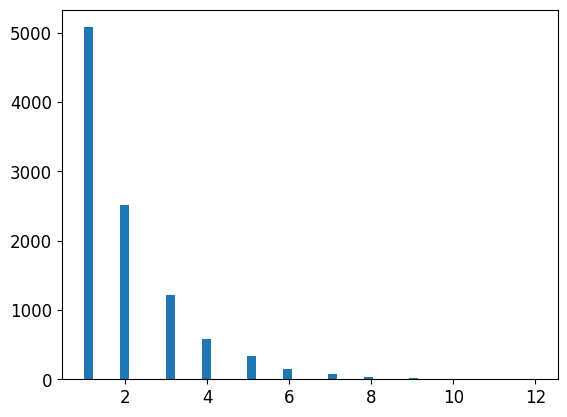

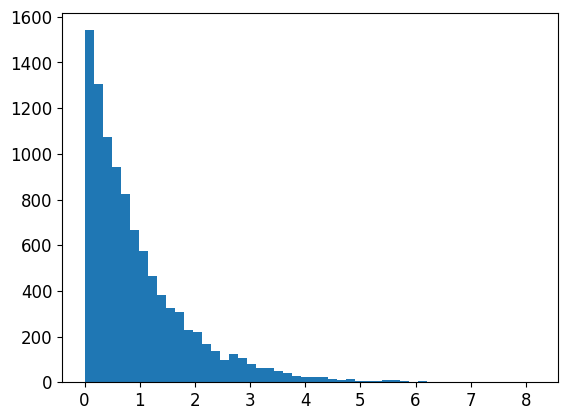

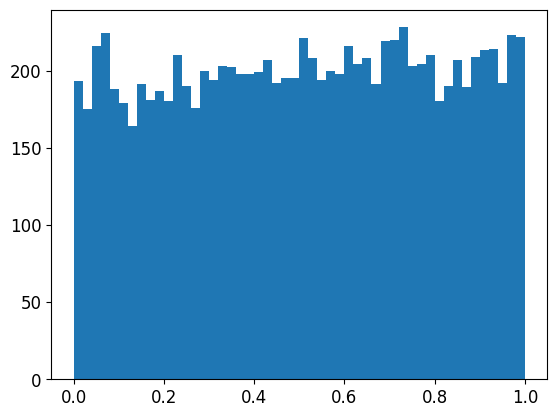

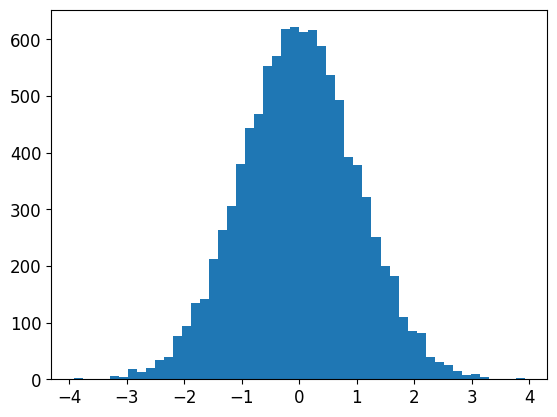

In [ ]:
from scipy.stats import geom, expon, norm, uniform

# 기하분포
geom_distrib=geom(0.5).rvs(10000, random_state=42)
# 지수분포
expon_distrib=expon().rvs(10000, random_state=42)
# 균등분포
uniform_distrib=uniform().rvs(10000)
# 정규분포
norm_distrib=norm().rvs(size=10000, random_state=42)

# 발생할 확률이 0.5인 사건이 몇 번 시도하면 발생하는가를 10,000번 실험한 결과
plt.hist(geom_distrib, bins=50)
plt.show()
# 특정 사건이 발생할 때까지 걸리는 시간을 10,000번 실험한 결과
plt.hist(expon_distrib, bins=50)
plt.show()
# 0과 1사의 실수를 임의로, 하지만 균등하게 10,000번 선택한 결과
plt.hist(uniform_distrib, bins=50)
plt.show()
# 무작위로 10,000개의 숫자를 선택한 결과. 단, 표준정규분포를 따라야 함.
plt.hist(norm_distrib, bins=50)
plt.show()

### 앙상블 방법

결정 트리 모델 하나보다 랜덤 포레스트와 결정 트리 모델을 함께 사용하면 보다 좋은 성능을 얻을 수 있었다.
이처럼 최고 성능을 보이는 개별 모델을 조합하면 보다 좋은 성능을 얻을 수 있다.
특히,  각각의 모델이 각기 많이 다른 종류의 오차를 만들 때 더욱 효과를 볼 수 있다.
이런 방법을 **앙상블 방법**이라 부르며 7장에서 자세히 다룬다.

### 최상의 모델과 오차 분석

그리드 탐색과 랜덤 탐색 등을 통해 얻어진 최상의 모델을 분석해서
문제에 대한 보다 좋은 통창을 얻을 수 있다.

예를 들어, 앞서 그리드 탐색을 통해 얻어진 최상의 랜덤 포레스트 모델에서
사용된 특성들 각각의 중요도를 `feature_importances_` 인스턴스 속성에 저장되어 있다.

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03])

중요도와 특성 이름을 함께 표시할 수 있다.

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # 예전 방식
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.3790092248170967), 'median_income'),
 (np.float64(0.16570630316895876), 'INLAND'),
 (np.float64(0.10703132208204354), 'pop_per_hhold'),
 (np.float64(0.06965425227942929), 'longitude'),
 (np.float64(0.0604213840080722), 'latitude'),
 (np.float64(0.054778915018283726), 'rooms_per_hhold'),
 (np.float64(0.048203121338269206), 'bedrooms_per_room'),
 (np.float64(0.04218822024391753), 'housing_median_age'),
 (np.float64(0.015849114744428634), 'population'),
 (np.float64(0.015554529490469328), 'total_bedrooms'),
 (np.float64(0.01524505568840977), 'total_rooms'),
 (np.float64(0.014934655161887776), 'households'),
 (np.float64(0.006792660074259966), '<1H OCEAN'),
 (np.float64(0.0030281610628962747), 'NEAR OCEAN'),
 (np.float64(0.0015247327555504937), 'NEAR BAY'),
 (np.float64(7.834806602687504e-05), 'ISLAND')]

위 정보를 특성들의 중요도를 확인할 수 있으며, 중요 특성과 그렇지 않은 특성을 구분할 수 있다.
예를 들어, 중간 소득(median income)과 INLAND(내륙, 해안 근접도)가 가장 중요한 특성으로
확인된다. 반면에 해안 근접도의 다른 네 가지 특성은 별로 중요해 보이지 않는다.

이런 점들을 이용하여 특성을 추가하거나 삭제하고, 이상치 등을 제거하는 등의 방식을 이용하여
보다 좋은 성능의 학습 모델을 생성할 수 있다.

### 테스트 세트로 최상의 모델 평가하기

지금까지 전혀 사용하지 않은 테스트 세트를 이용하여 이제까지
얻은 최상의 모델의 성능을 평가하자.

* 최상의 모델 확인

In [ ]:
final_model = grid_search.best_estimator_

* 테스트 세트 전처리 하기. 과정은 훈련 세트의 경우와 동일하다.
    단, `full_pipeline` 변환기의 `transform()` 메서드를 직접 활용한다.
    즉, `fit()` 메서드는 전혀 사용하지 않는 것에 주의한다.
    (훈련 세트의 전처리에서는 `fit_transform()` 메서드를 사용하였음)

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

* 최상의 모델을 이용하여 예측하기

In [ ]:
final_predictions = final_model.predict(X_test_prepared)

* 예측 결과의 오차 계산

In [ ]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

np.float64(47873.26095812988)

테스트 세트에 대한 평균 제곱근 오차가 이전에 교차 검증을 통해 얻은 결과보다 좋다
하지만 이것이 그리드 탐색을 통해 다양한 하이퍼파라미터 조합을 실험하여 얻은 결과가
항상 좋다라는 결론을 의미하지는 않는다.
보통은 반대의 결과가 나오기 때문이다.
따라서 테스트 세트에 대한 성능을 높이기 위해 하이퍼파라미터를 일부러 튜닝하는 것은
피해야 한다. 그렇게 하면 과대적합된 모델을 얻게될 가능성이 높아지기 때문이다.

#### 평균 제곱근 오차의 t-분포 신뢰구간 확인하기

테스트 세트에 대한 RMSE를 어느 정도 믿을 수 있을지
t-분포 95% 신뢰 구간을 계산해보자.

아래 코드는 scipy 패키지의 stats 모듈을 활용한다.
코드의 내용과 t-분포 신뢰구간에 대한 설명은 여기서는 중요하지 않다.

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45893.36082829, 49774.46796717])

위 결과에 따르면,
임의의 캘리포니아 구역에 대해 예측된 중간 주택 가격과 실제 중간 주택 가격의 차이는
95%의 확률로 45,685달러에서 49,691 달러 정도 된다.

#### 수동으로  t-분포 신뢰구간 계산하기

다음과 같이 수동으로 계산할 수도 있다.
하지만 여기서는 참조만 한다.

In [ ]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(np.float64(45893.360828285535), np.float64(49774.46796717361))

또는 t-점수 대신 z-점수를 사용할 수도 있다. 역시 참조만 한다.

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(np.float64(45893.9540110131), np.float64(49773.92103065038))

# 연습문제

## 1.

질문: 서포트 벡터 머신 회귀(`sklearn.svm.SVR`)를 `kernel=“linear”`(하이퍼파라미터 `C`를 바꿔가며)나 `kernel=“rbf”`(하이퍼파라미터 `C`와 `gamma`를 바꿔가며) 등의 다양한 하이퍼파라미터 설정으로 시도해보세요. 지금은 이 하이퍼파라미터가 무엇을 의미하는지 너무 신경 쓰지 마세요. 최상의 `SVR` 모델은 무엇인가요?

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
      {'kernel': ['linear'], 'C': [1,10,100]},
      {'kernel': ['rbf'], 'C': [1,10,100], 'gamma': [1,0.1,0.01]}
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .................................C=1, kernel=linear; total time=  30.9s
[CV] END .................................C=1, kernel=linear; total time=  29.9s
[CV] END .................................C=1, kernel=linear; total time=  21.3s
[CV] END .................................C=1, kernel=linear; total time=  15.3s
[CV] END .................................C=1, kernel=linear; total time=  16.3s
[CV] END ................................C=10, kernel=linear; total time=  14.3s
[CV] END ................................C=10, kernel=linear; total time=  14.9s
[CV] END ................................C=10, kernel=linear; total time=  15.0s
[CV] END ................................C=10, kernel=linear; total time=  14.9s
[CV] END ................................C=10, kernel=linear; total time=  15.0s
[CV] END ...............................C=100, kernel=linear; total time=  14.5s
[CV] END ...............................C=100, k

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1, 10, 100], 'gamma': [1, 0.1, 0.01],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

최상 모델의 (5-폴드 교차 검증으로 평가한) 점수는 다음과 같습니다:

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

np.float64(71635.55362813479)

`RandomForestRegressor`보다 훨씬 좋지 않네요. 최상의 하이퍼파라미터를 확인해 보겠습니다:

In [ ]:
grid_search.best_params_

{'C': 100, 'kernel': 'linear'}

선형 커널이 RBF 커널보다 성능이 나은 것 같습니다. `C`는 테스트한 것 중에 최대값이 선택되었습니다. 따라서 (작은 값들은 지우고) 더 큰 값의 `C`로 그리드서치를 다시 실행해 보아야 합니다. 아마도 더 큰 값의 `C`에서 성능이 높아질 것입니다.

## 2.

질문: `GridSearchCV`를 `RandomizedSearchCV`로 바꿔보세요.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# expon(), reciprocal()와 그외 다른 확률 분포 함수에 대해서는
# https://docs.scipy.org/doc/scipy/reference/stats.html를 참고하세요.

# 노트: kernel 매개변수가 "linear"일 때는 gamma가 무시됩니다.
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)# 이 부분을 채우세요.
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x79e5b34333b0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x79e5b3b2bfb0>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error')

최상 모델의 (5-폴드 교차 검증으로 평가한) 점수는 다음과 같습니다:

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

np.float64(54751.69009488048)

이제 `RandomForestRegressor`의 성능에 훨씬 가까워졌습니다(하지만 아직 차이가 납니다). 최상의 하이퍼파라미터를 확인해 보겠습니다:

In [ ]:
rnd_search.best_params_

{'C': np.float64(157055.10989448498),
 'gamma': np.float64(0.26497040005002437),
 'kernel': 'rbf'}

이번에는 RBF 커널에 대해 최적의 하이퍼파라미터 조합을 찾았습니다. 보통 랜덤서치가 같은 시간안에 그리드서치보다 더 좋은 하이퍼파라미터를 찾습니다.

여기서 사용된 `scale=1.0`인 지수 분포를 살펴보겠습니다. 일부 샘플은 1.0보다 아주 크거나 작습니다. 하지만 로그 분포를 보면 대부분의 값이 exp(-2)와 exp(+2), 즉 0.1과 7.4 사이에 집중되어 있음을 알 수 있습니다.

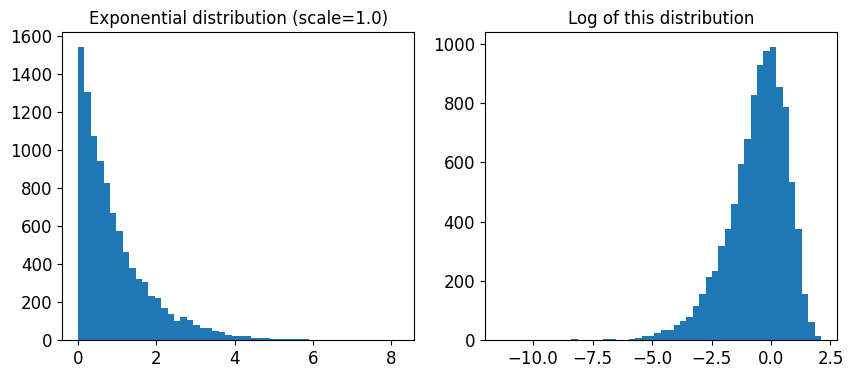

In [ ]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

`C`에 사용된 분포는 매우 다릅니다. 주어진 범위안에서 균등 분포로 샘플링됩니다. 그래서 오른쪽 로그 분포가 거의 일정하게 나타납니다. 이런 분포는 원하는 스케일이 정확이 무엇인지 모를 때 사용하면 좋습니다:

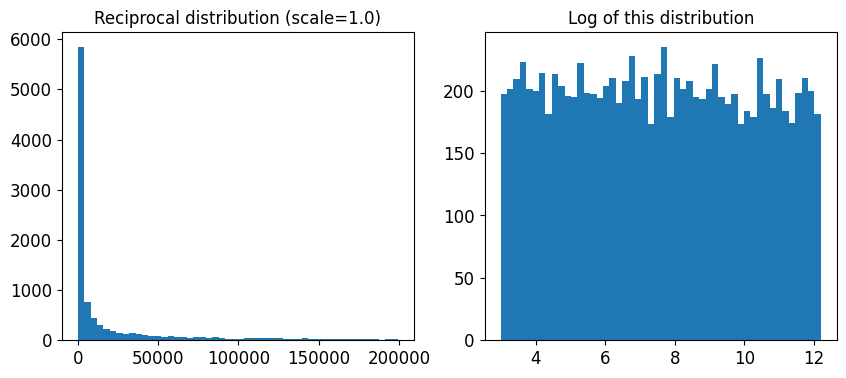

In [ ]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

`reciprocal()` 함수는 하이퍼파라미터의 스케일에 대해 전혀 감을 잡을 수 없을 때 사용합니다(오른쪽 그래프에서 볼 수 있듯이 주어진 범위안에서 모든 값이 균등합니다). 반면 지수 분포는 하이퍼파라미터의 스케일을 (어느정도) 알고 있을 때 사용하는 것이 좋습니다.

## 3.

질문: 가장 중요한 특성을 선택하는 변환기를 준비 파이프라인에 추가해보세요.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)# 이 부분을 채우세요.
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

노트: 이 특성 선택 클래스는 이미 어떤 식으로든 특성 중요도를 계산했다고 가정합니다(가령 `RandomForestRegressor`을 사용하여). `TopFeatureSelector`의 `fit()` 메서드에서 직접 계산할 수도 있지만 (캐싱을 사용하지 않을 경우) 그리드서치나 랜덤서치의 모든 하이퍼파라미터 조합에 대해 계산이 일어나기 때문에 매우 느려집니다.

선택할 특성의 개수를 지정합니다:

In [ ]:
k = 5

최상의 k개 특성의 인덱스를 확인해 보겠습니다:

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

NameError: name 'feature_importances' is not defined

In [ ]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

최상의 k개 특성이 맞는지 다시 확인합니다:

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(np.float64(0.3790092248170967), 'median_income'),
 (np.float64(0.16570630316895876), 'INLAND'),
 (np.float64(0.10703132208204354), 'pop_per_hhold'),
 (np.float64(0.06965425227942929), 'longitude'),
 (np.float64(0.0604213840080722), 'latitude')]

좋습니다. 이제 이전에 정의한 준비 파이프라인과 특성 선택기를 추가한 새로운 파이프라인을 만듭니다:

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

처음 3개 샘플의 특성을 확인해 보겠습니다:

In [ ]:
housing_prepared_top_k_features[0:3]

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264,  1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122,  1.        ]])

최상의 k개 특성이 맞는지 다시 확인합니다:

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264,  1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122,  1.        ]])

성공입니다!  :)

## 4.

질문: 전체 데이터 준비 과정과 최종 예측을 하나의 파이프라인으로 만들어보세요.

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_regressor', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat', OneHotEncoder(...
                 TopFeatureSelector(feature_importances=array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03]),
                                    k=5)),
                ('svm_regressor',
                 SVR(C=np.float64(157055.10989448498),
                     gamma=np.float64(0.26497040005002437)))])

몇 개의 샘플에 전체 파이프라인을 적용해 보겠습니다:

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 83384.49158095 299407.90439234  92272.03345144 150173.16199041]
Labels:		 [72100.0, 279600.0, 82700.0, 112500.0]


전체 파이프라인이 잘 작동하는 것 같습니다. 물론 예측 성능이 아주 좋지는 않습니다. `SVR`보다 `RandomForestRegressor`가 더 나은 것 같습니다.

## 5.

질문: `GridSearchCV`를 사용해 준비 단계의 옵션을 자동으로 탐색해보세요.

In [ ]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=3,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

NameError: name 'feature_importances' is not defined

In [ ]:
grid_search_prep.best_params_

최상의 `Imputer` 정책은 `most_frequent`이고 거의 모든 특성이 유용합니다(16개 중 15개). 마지막 특성(`ISLAND`)은 잡음이 추가될 뿐입니다.